In [1]:
import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, rat):
        x = x + (self.pe[:x.size(0), :]) * rat
        return self.dropout(x)

class TFModule(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, num_hiddens, num_heads, embeddropout_rate, dropout_rate, pos_ratio):
        super(TFModule, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_embed = PositionalEncoding(embed_size, embeddropout_rate, 1025)
        self.pos_ratio = pos_ratio
        
        self.encoder_layer = nn.TransformerEncoderLayer(
                                        d_model=embed_size,
                                        dim_feedforward=num_hiddens,
                                        nhead=num_heads, 
                                        dropout=dropout_rate, 
                                        activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        self.decoder = nn.Linear(embed_size, vocab_size) # 初始时间步和最终时间步的隐藏状态作为全连接层输入

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)
    
    def forward(self, inputs):
        
        word_emb = self.embedding(inputs.permute(1, 0))
        embeddings = self.pos_embed(word_emb, self.pos_ratio)
        
        outputs = self.transformer_encoder(embeddings, mask=self._generate_square_subsequent_mask(embeddings.shape[0]))

        output = outputs.permute(1, 0, 2)
        outs = output.reshape(output.size(0)*output.size(1), output.size(2))
        ret = self.decoder(outs)
        return ret

In [3]:
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

In [4]:
class Corpus(object):
    def __init__(self, train_batch_size=20, eval_batch_size=10, bptt=35):
        self.bptt = bptt
        train_iter = WikiText2(split='train')
        self.tokenizer = get_tokenizer('basic_english')
        counter = Counter()
        for line in train_iter:
            counter.update(self.tokenizer(line))
        self.vocab = Vocab(counter)
        train_iter, val_iter, test_iter = WikiText2()
        train_data = self.data_process(train_iter)
        val_data = self.data_process(val_iter)
        test_data = self.data_process(test_iter)

        self.train_data = self.batchify(train_data, train_batch_size)
        self.val_data = self.batchify(val_data, eval_batch_size)
        self.test_data = self.batchify(test_data, eval_batch_size)

    def data_process(self, raw_text_iter):
        data = [torch.tensor([self.vocab[token] for token in self.tokenizer(item)],
                           dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

    def batchify(self, data, batch_size):
        # Divide the dataset into batch_size parts.
        nbatch = data.size(0) // batch_size
        # Trim off any extra elements that wouldn't cleanly fit (remainders).
        data = data.narrow(0, 0, nbatch * batch_size)
        # Evenly divide the data across the batch_size batches.
        data = data.view(batch_size, -1).t().contiguous()
        return data.to(device)

    def get_batch(self, source, i):
        seq_len = min(self.bptt, len(source) - 1 - i)
        data = source[i:i+seq_len]
        target = source[i+1:i+1+seq_len].reshape(-1)
        return data, target

    def get_ntokens(self):
        return len(self.vocab.stoi)

In [5]:
import argparse
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable

import data
import model
class args():
    pos_ratio = 0.1
    emsize = 100
    nhid = 200
    nlayers = 3
    nhead = 20
    lr = 0.5
    epochs = 1000
    batch_size = 32
    bptt = 256
    embeddropout = 0.1
    dropout = 0.5
    tied = False
    seed = 1234
    save = 'model.pt'

In [6]:
data_loader = Corpus(train_batch_size=args.batch_size,
                     eval_batch_size=args.batch_size,
                     bptt=args.bptt)

In [7]:
ntokens = len(data_loader.vocab.itos)
model = TFModule(ntokens, args.emsize, args.nlayers, args.nhid, args.nhead, args.embeddropout, args.dropout, args.pos_ratio)

In [8]:
model

TFModule(
  (embedding): Embedding(28783, 100)
  (pos_embed): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=200, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=200, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_fe

In [17]:
model.transformer_encoder.layers[0].self_attn
for o in model.transformer_encoder.layers:
    print(o)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
  )
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)
TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
  )
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dr

In [10]:
if 1:
    src = torch.rand(3,2,100)
    A, B = model.transformer_encoder.layers[0].self_attn(src, src, src, attn_mask = model._generate_square_subsequent_mask(src.shape[0]))
    print(src.shape,B.shape,"\n",B)

torch.Size([3, 2, 100]) torch.Size([2, 3, 3]) 
 tensor([[[1.2000, 0.0000, 0.0000],
         [0.4409, 0.5018, 0.0000],
         [0.3238, 0.3426, 0.2377]],

        [[1.2000, 0.0000, 0.0000],
         [0.4189, 0.3533, 0.0000],
         [0.2025, 0.3316, 0.3314]]], grad_fn=<DivBackward0>)


In [11]:
torch.rand(2,3)

tensor([[0.6419, 0.2552, 0.7288],
        [0.2828, 0.3613, 0.2864]])

In [60]:
test1 = "i get up , eat bread milk ."
test2 = "i get up , drink bread milk ."
model.load_state_dict(torch.load('parameter-2.pkl'))

<All keys matched successfully>

In [61]:
def fuck(s):
    model.eval()
    a = s.split(' ')
    l = len(a)
    src = []
    for o in a:
        src.append(data_loader.vocab.stoi[o])
    print(src)
    src = torch.tensor(src).reshape(1,l)
    
    word_emb = model.embedding(src.permute(1, 0))
    embeddings = model.pos_embed(word_emb, model.pos_ratio)
    
    msk = model._generate_square_subsequent_mask(embeddings.shape[0])
    for i in range(embeddings.shape[0]):
        for j in range(embeddings.shape[0]):
            msk[i,j]=0.
    
    outputs0 = model.transformer_encoder.layers[0](embeddings, src_mask=msk)
    outputs1 = model.transformer_encoder.layers[1](outputs0, src_mask=msk)
    outputs2 = model.transformer_encoder.layers[2](outputs1, src_mask=msk)
    
    outputs = model.transformer_encoder(embeddings, mask=msk)
    
#     print(outputs)
#     print(outputs2)
    _, att0 = model.transformer_encoder.layers[0].self_attn(embeddings, embeddings, embeddings, attn_mask=msk)
    _, att1 = model.transformer_encoder.layers[1].self_attn(outputs0, outputs0, outputs0, attn_mask=msk)
    _, att2 = model.transformer_encoder.layers[2].self_attn(outputs1, outputs1, outputs1, attn_mask=msk)
    print(att0.shape)
    print(att0[0,4,:])
    print(att1[0,4,:])
    print(att2[0,4,:])
#     print(att0)
#     print(att1)
#     print(att2)
    return att0, att1, att2
    
fuck(test1)
print("fin")

[65, 647, 75, 3, 4338, 5450, 5751, 4]
torch.Size([1, 8, 8])
tensor([0.1590, 0.0871, 0.1049, 0.0998, 0.1236, 0.1488, 0.1014, 0.1753],
       grad_fn=<SliceBackward>)
tensor([0.1489, 0.1411, 0.0488, 0.2099, 0.0933, 0.0735, 0.0806, 0.2040],
       grad_fn=<SliceBackward>)
tensor([0.1492, 0.1680, 0.0538, 0.2073, 0.0397, 0.0729, 0.0627, 0.2463],
       grad_fn=<SliceBackward>)
fin


In [62]:

fuck(test2)
print("fin")

[65, 647, 75, 3, 7429, 5450, 5751, 4]
torch.Size([1, 8, 8])
tensor([0.1486, 0.1242, 0.1031, 0.1784, 0.0908, 0.0983, 0.1141, 0.1424],
       grad_fn=<SliceBackward>)
tensor([0.1450, 0.1371, 0.0592, 0.1716, 0.0799, 0.0796, 0.1058, 0.2218],
       grad_fn=<SliceBackward>)
tensor([0.1311, 0.1519, 0.0516, 0.2215, 0.0423, 0.0600, 0.0574, 0.2841],
       grad_fn=<SliceBackward>)
fin


[65, 647, 75, 3, 4338, 5450, 5751, 4]
torch.Size([1, 8, 8])
tensor([0.1590, 0.0871, 0.1049, 0.0998, 0.1236, 0.1488, 0.1014, 0.1753],
       grad_fn=<SliceBackward>)
tensor([0.1489, 0.1411, 0.0488, 0.2099, 0.0933, 0.0735, 0.0806, 0.2040],
       grad_fn=<SliceBackward>)
tensor([0.1492, 0.1680, 0.0538, 0.2073, 0.0397, 0.0729, 0.0627, 0.2463],
       grad_fn=<SliceBackward>)
tensor(0.8899, grad_fn=<MulBackward0>)
tensor(0.1705, grad_fn=<MulBackward0>)
tensor(0.3494, grad_fn=<MulBackward0>)
tensor(0.2983, grad_fn=<MulBackward0>)
tensor(0.5357, grad_fn=<MulBackward0>)
tensor(0.7885, grad_fn=<MulBackward0>)
tensor(0.3142, grad_fn=<MulBackward0>)
1.0


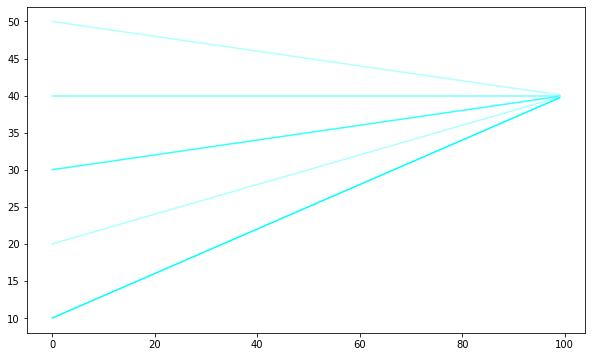

In [114]:
import numpy as np
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
 
#直线
x1=np.arange(-20, 20, 1)
x2=(3*x1-12)/2

n = 8

X = []
Y = []
for i in range(n):
    X.append([])
    Y.append([])
    for j in range(n):
        x = np.arange(0,100,1) # 0,(n-i)*10 -> 100, (n-j)*10
        y = (((n-j)*10-(n-i)*10)/100)*x + (n-i)*10
        X[-1].append(x)
        Y[-1].append(y)



def getchar(i):
    if i<10: return str(i)
    return chr(i-10+ord('A'))
def gencolor(rat):
    num = int((1-rat)*255)
    return '#'+getchar(num//16)+getchar(num%16)+'FFFF'

# plt.plot(x1,x2,color=gencolor(0.1)) 

tab0, tab1, tab2 = fuck(test1)
tab0 = tab0.reshape(n,n)
tab1 = tab1.reshape(n,n)
tab2 = tab2.reshape(n,n)

def trans(x):
    t = min(1.,max(0.,(x-0.07)*10))
    return t

for i in range(n):
    print(trans(tab0[4,i]))

for i in range(4,5):
    for j in range(3,n):
        plt.plot(X[j][i],Y[j][i],color=gencolor(trans(tab0[i,j]))) 

plt.show()